## Machine Learning

In [1]:
# Versão da Linguagem Python
from platform import python_version
print("Versão da Linguagem Python Usada Neste Jupyter Notebook: ", python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook:  3.9.4


### Classificação de Imagens com Deep Learning e PyTorch

![titulo](imagens/deep_learning.png)


## Definição do Problema

![title](imagens/CV.jpeg)

## Instalando e Carregando os Pacotes

In [2]:
# import Packega
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Rodolfo Terra | Ciência de Dados" --iversions

Author: Rodolfo Terra | Ciência de Dados

torchvision: 0.9.1
tensorflow : 2.5.0rc0
numpy      : 1.19.5
torch      : 1.8.1
matplotlib : 3.4.1



### Verificando a GPU

Pode ser útil acelerar o tempo de treinamento usando uma GPU. CUDA é uma plataforma da Nvidia que permite usarmos as GPUs (Nvidia) para processamento paralelo). Os frameworks de Deep Learning dependem da plataforma CUDA para o processamento em GPU.

In [4]:
# Executar somente se a máquina tiver GPU e Plataforma CUDA instalada
#!nvidia-smi

In [5]:
# Verificando se a plataforma CUDA está disponível
train_on_gpu = torch.cuda.is_available()

In [6]:
# Mensgagem para o usurário
if not train_on_gpu:
    print("Plataforma CUDA não está disponível! O treinamento será realizado com a CPU...")
else:
    print("Plataforma CUDA está dfisponível! O treinamento será realizado com a GPU...")

Plataforma CUDA não está disponível! O treinamento será realizado com a CPU...


## Checando o Hardware Disponível no Servidor - CPU E GPUs

In [7]:
# Lista todos os dispositivos disponíveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5198956467157036812
]


In [8]:
print("Número Disponível de GPUs:", len(tensorflow.config.experimental.list_physical_devices("GPU")))
print("Número Disponível de CPUs:", len(tensorflow.config.experimental.list_physical_devices("CPU")))

Número Disponível de GPUs: 0
Número Disponível de CPUs: 1


In [9]:
tensorflow.config.experimental.list_physical_devices("CPU")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Carregando o Dataset

http://pytorch.org/docs/stable/torchvision/datasets.html

O download pode demorar um minuto. Carregamos os dados de treinamento e teste, dividimos os dados de treinamento em um conjunto de treinamento e validação e, em seguida, criamos DataLoaders para cada um desses conjuntos de dados.

Dataset usado: https://www.cs.toronto.edu/~kriz/cifar.html

In [10]:
# Função que converte os dados em um tensor normalizado
transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomização horizontal
                             transforms.RandomRotation(10), # Randomização na rotação
                             transforms.ToTensor(), # converter as imagen em tensor
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # normalizar as imagens

In [11]:
# Download dos Dados treinado
dados_treino = datasets.CIFAR10('dados',
                                 train = True,
                                 download = True,
                                 transform = transform)

Files already downloaded and verified


In [12]:
dados_teste = datasets.CIFAR10('dados',
                                 train = False,
                                 download = True,
                                 transform = transform)

Files already downloaded and verified


## Preparando os Dados Loaders

In [13]:
# Dados de Treino
dados_treino

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dados
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [14]:
# Dados de Teste
dados_teste

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dados
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [15]:
# Número de amostra de treino
num_amostra_treino = len(dados_treino)
num_amostra_treino

50000

In [16]:
# Criando um índice e o tornamos rendômico
indices = list(range(num_amostra_treino))
np.random.shuffle(indices)

In [17]:
# Percentual dos dados de treino que usaremos no dataset de validação
valid_size = 0.2

In [18]:
# Agora fazemos o split para os dados de trino e validação
split = int(np.floor(valid_size * num_amostra_treino))
idx_treino, idx_valid = indices[split:], indices[:split]

In [19]:
# Definimos as amostras de treino
amostras_treino = SubsetRandomSampler(idx_treino)

In [20]:
# Definimos as amostras de validação
amostras_valid = SubsetRandomSampler(idx_valid)

#### Agora preparamos os data loaders

In [21]:
# Número de subprocessos para carregar os dados
num_workers = 0

# Número de amostras por batch
batch_size = 20

In [22]:
# Data Loader de dados de Treino
loader_treino = torch.utils.data.DataLoader(dados_treino,
                                           batch_size = batch_size,
                                           sampler = amostras_treino,
                                           num_workers = num_workers)

In [41]:
# Data Loader de dados de Validação
loader_valid = torch.utils.data.DataLoader(dados_treino,
                                           batch_size = batch_size,
                                           sampler = amostras_valid,
                                           num_workers = num_workers)

In [42]:
# Data Loader de dados de Teste
loader_teste = torch.utils.data.DataLoader(dados_teste,
                                           batch_size = batch_size,
                                           num_workers = num_workers)

In [43]:
# Lista de classes das imagens
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Visualizando os Dados

In [44]:
# Função para desnormalização das imagens
def imshow(img):
    
    # Desfaz a normalização
    img = img / 2 + 0.5
    
    # Converte en tensor e imprime
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [45]:
# Obtém um batch de dados de treino
dataiter = iter(loader_treino)
imagens, labels = dataiter.next()

In [46]:
# Converte as imagens em formato NumPy
imagens = imagens.numpy()

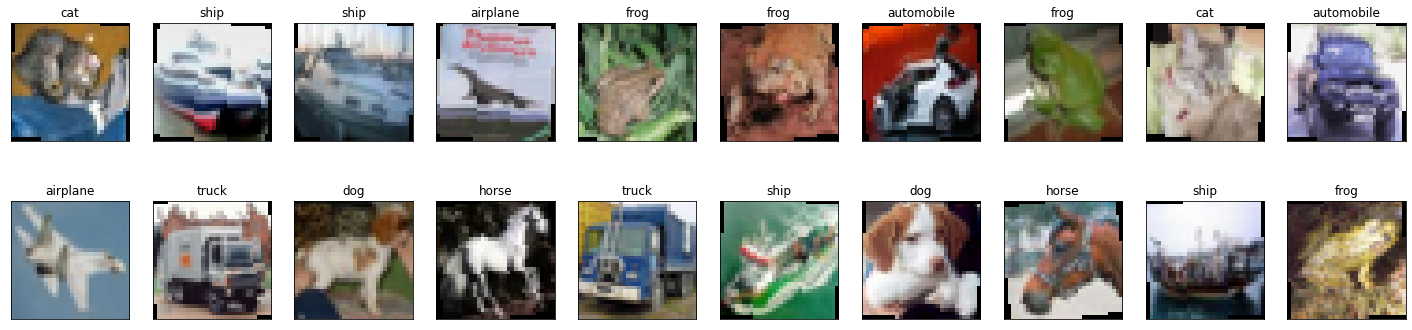

In [47]:
# Plot de um batch de imagens de treino

# Área de plotagem
fig = plt.figure(figsize = (25, 6))

# Loop e print
for idx in np.arange(20):
    
    # Cria os subplot
    ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
    
    #Desfgaz a normalização
    imshow(imagens[idx])
    
    #Coloca o título
    ax.set_title(classes[labels[idx]])

## Visualizar uma imagem com mais detalhe

In [48]:
# Extraímops os canais de cores
rgb_img = np.squeeze(imagens[11])
channels = ['Canal Vermelho (REd)', "Canal Vermelho (Green)", "Canal Vermelho (Blue)"]

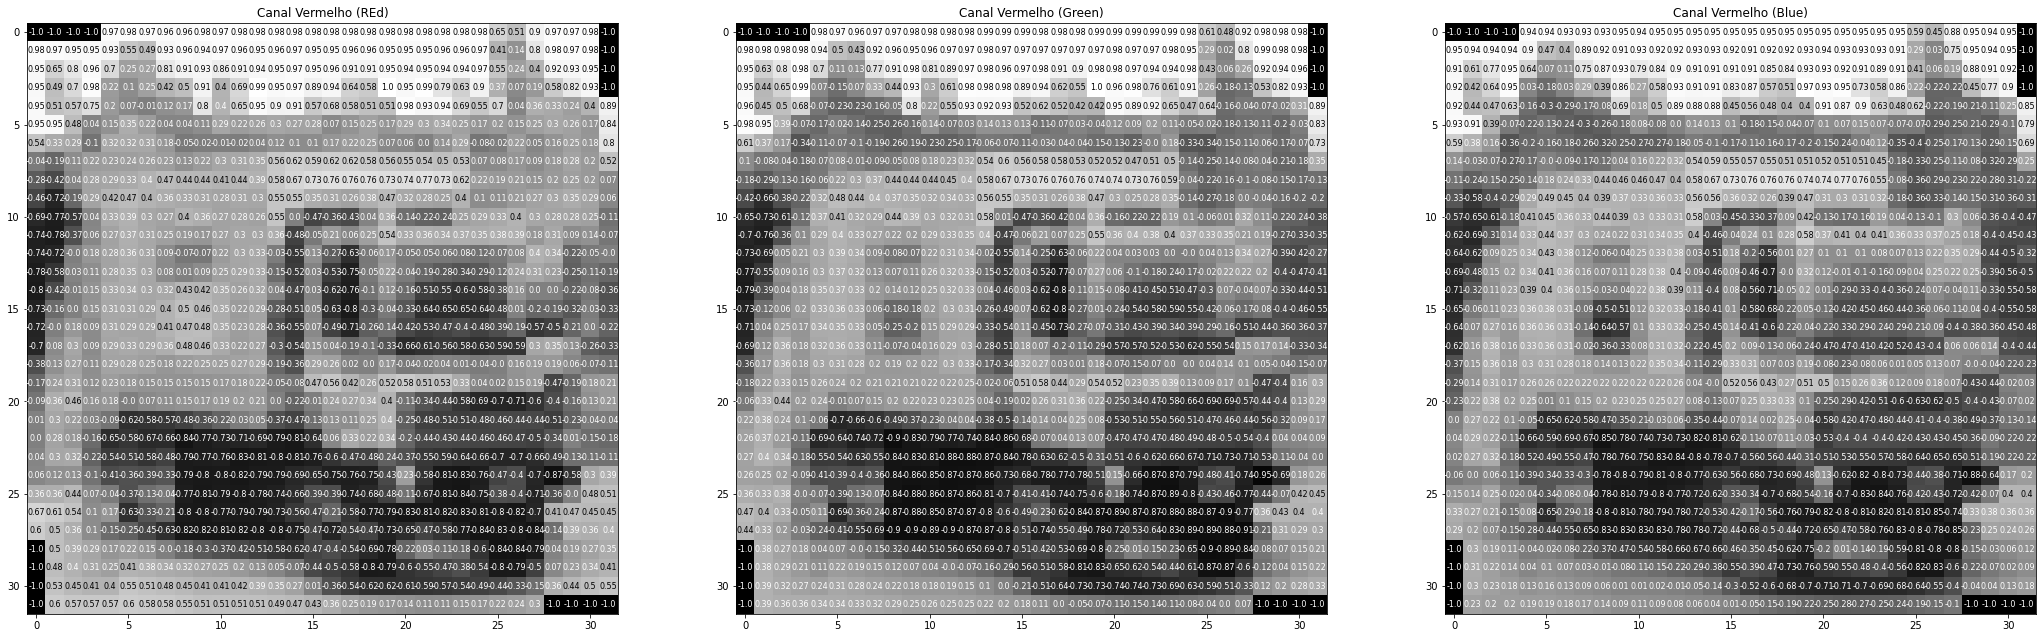

In [49]:
# Loop e print

# Área de plotagem
fig = plt.figure(figsize = (36, 36))

# Loop pelas imaghens
for idx in np.arange(rgb_img.shape[0]):
    
    # Subplot
    ax = fig.add_subplot(1,3, idx + 1)
    
    # Índice
    img  = rgb_img[idx]
    
    # Mostra a imagem em escala de cinza
    ax.imshow(img, cmap = 'gray')
    
    # Título 
    ax.set_title(channels[idx])
    
    # Largura e altura da imagem
    width, height = img.shape
    
    #Limite
    thresh = img.max()/2.5
    
    # Loop
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val),
                       xy = (y,x),
                       horizontalalignment = 'center',
                       verticalalignment = 'center',
                       size = 8,
                       color = 'white' if img[x][y] < thresh else 'black')
    

## Definindo a Arquitetura da Rede

http://pytorch.org/docs/stable/nn.html

Vamos definir uma arquitetura CNN (Convolutional Neural Network). 

* [Camadas convolucionais](https://pytorch.org/docs/stable/nn.html#conv2d), podem ser consideradas como uma pilha de imagens filtradas.

* [Camadas de Maxpool](https://pytorch.org/docs/stable/nn.html#maxpool2d), reduzem o tamanho x-y de uma entrada, mantendo apenas os pixels mais _ativos_ da camada anterior.

* As camadas Linear + Dropout podem evitar sobreajuste e produzir uma saída de 10 dimensões.

In [50]:
# Arquitetura do Modelo
class ModeloCNN(nn.Module):
    
    # Método construtor
    def __init__(self):
        super(ModeloCNN, self).__init__()
        
        # Camada Convolucional de entrada 
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        
        # Camada Convolucional oculta 
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        
        # Camada Convolucional oculta 
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        # Camada de Max Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Camada Totalmente Conectada 1
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Camada Totalmente Conectada 2
        self.fc2 = nn.Linear(500, 10)
        
        # Camada de Dropout (Regularização)
        self.dropout = nn.Dropout(0.5)

    # Método Forward
    def forward(self, x):
        
        # Adiciona uma camada de ativação Relu para cada camada convolucional
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Faz o "achatamento" da matriz resultante da convolução e cria um vetor
        x = x.view(-1, 64 * 4 * 4)
        
        # Adiciona uma camada de dropout para regularização
        x = self.dropout(x)
        
        # Adiciona a 1ª camada oculta, com função de ativação relu
        x = F.relu(self.fc1(x))
        
        # Adiciona uma camada de dropout para regularização
        x = self.dropout(x)
        
        # Adiciona a 2ª camada oculta (classificação feita pelo modelo)
        x = self.fc2(x)
        return x

In [51]:
# Cria o modelo
modelo = ModeloCNN() ; print(modelo)

ModeloCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [52]:
# Movemos o modelo para a GPU se disponível ou CPU
if train_on_gpu:
    modelo.cuda()

## Função de perda

In [53]:
# Loss function como categorical cross-entropy
criterion = nn.CrossEntropyLoss()

## Otimizar

In [54]:
# Hiperparâmtero
taxa_aprendizado = 0.01

In [55]:
# Otimizador com SGD
optimizer = optim.SGD(modelo.parameters(), lr = taxa_aprendizado)

## Treinamento

Lembre-se de observar como a perda em treinamento e validação diminui com o tempo; se a perda em validação aumentar, isso indica um possível sobreajuste (overfitting)

In [59]:
# Número de épocas para treinar o modelo
num_epochs = 70

In [60]:
# hiperparâmetro para controlar a ,mudança do erro em validação
erro_valid_min = np.Inf

#### Treinando o modelo 

In [61]:
%%time
for epoch in range(1, num_epochs + 1):

    # Parâmetros para acompanhar o erro total em treinamento e validação
    erro_treino = 0.0
    erro_valid = 0.0
    
    # Inicia o treinamento do modelo
    modelo.train()
    
    # Loop pelos batches de dados de treino
    for batch_idx, (data, target) in enumerate(loader_treino):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Limpa os gradientes de todas as variáveis otimizadas
        optimizer.zero_grad()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Backward: calcula o gradiente da perda em relação aos parâmetros do modelo
        loss.backward()
        
        # Realiza uma única etapa de otimização (atualização dos parâmetros)
        optimizer.step()
        
        # Atualiza o erro total em treino
        erro_treino += loss.item() * data.size(0)
        
    # Inicia a validação do modelo
    modelo.eval()
    
    # Loop pelos batches de dados de validação
    for batch_idx, (data, target) in enumerate(loader_valid):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Atualiza o erro total de validação
        erro_valid += loss.item() * data.size(0)
    
    # Calcula o erro médio
    erro_treino = erro_treino / len(loader_treino.dataset)
    erro_valid = erro_valid / len(loader_valid.dataset)
        
    # Print
    print('\nEpoch: {} \tErro em Treinamento: {:.6f} \tErro em Validação: {:.6f}'.format(epoch, 
                                                                                         erro_treino, 
                                                                                         erro_valid))
    
    # Salva o modelo sempre que a perda em validação diminuir
    if erro_valid <= erro_valid_min:
        print('Erro em Validação foi Reduzido ({:.6f} --> {:.6f}). Salvando o modelo...'.format(erro_valid_min,
                                                                                                 erro_valid))
        torch.save(modelo.state_dict(), 'modelos/modelo_final.pt')
        erro_valid_min = erro_valid


Epoch: 1 	Erro em Treinamento: 1.218102 	Erro em Validação: 0.238239
Erro em Validação foi Reduzido (inf --> 0.238239). Salvando o modelo...

Epoch: 2 	Erro em Treinamento: 1.210779 	Erro em Validação: 0.235755
Erro em Validação foi Reduzido (0.238239 --> 0.235755). Salvando o modelo...

Epoch: 3 	Erro em Treinamento: 1.201173 	Erro em Validação: 0.234992
Erro em Validação foi Reduzido (0.235755 --> 0.234992). Salvando o modelo...

Epoch: 4 	Erro em Treinamento: 1.193852 	Erro em Validação: 0.232532
Erro em Validação foi Reduzido (0.234992 --> 0.232532). Salvando o modelo...

Epoch: 5 	Erro em Treinamento: 1.182027 	Erro em Validação: 0.236036

Epoch: 6 	Erro em Treinamento: 1.172761 	Erro em Validação: 0.228521
Erro em Validação foi Reduzido (0.232532 --> 0.228521). Salvando o modelo...

Epoch: 7 	Erro em Treinamento: 1.148507 	Erro em Validação: 0.226475
Erro em Validação foi Reduzido (0.228521 --> 0.226475). Salvando o modelo...

Epoch: 8 	Erro em Treinamento: 1.151190 	Erro em Val

## Carrega o Modelo Final

In [62]:
# Carrega o modelo 
modelo.load_state_dict(torch.load('modelos/modelo_final.pt'))

<All keys matched successfully>

## Testando e Avaliando o Modelo

Testamos o modelo treinado em dados nunca visto anteriormente! Um resultado "bom" será uma CNN que obtenha cerca de 70% (ou mais) de precisão nas imagens de teste.

In [63]:
# Erro em teste
erro_teste = 0.0

In [64]:
# Controle de acerto do modelo
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [65]:
# Inicia a avaliação do modelo
modelo.eval()

# Loop pelos batches de dados de teste
for batch_idx, (data, target) in enumerate(loader_teste):
    
    # Move os tensores para GPU se disponível
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # Forward
    output = modelo(data)
    
    # Calcula o erro
    loss = criterion(output, target)
    
    # Atualiza o erro em teste
    erro_teste += loss.item() * data.size(0)
    
    # Converte probabilidades de saída em classe prevista
    _, pred = torch.max(output, 1)    
    
    # Compara as previsões com o rótulo verdadeiro
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calcula a precisão do teste para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Erro médio em teste
erro_teste = erro_teste / len(loader_teste.dataset)
print('\nErro em Teste: {:.6f}\n'.format(erro_teste))

# Calcula a acurácia para cada classe
for i in range(10):
    if class_total[i] > 0:
        print('Acurácia em Teste da classe %5s: %2d%% (%2d/%2d)' % (classes[i], 
                                                             100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), 
                                                             np.sum(class_total[i])))
    else:
        print('Acurácia em Teste de %5s:)' % (classes[i]))

# Calcula a acurácia total
print('\nAcurácia em Teste (Total): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct), 
                                                        np.sum(class_total)))


Erro em Teste: 0.586590

Acurácia em Teste da classe airplane: 83% (837/1000)
Acurácia em Teste da classe automobile: 93% (938/1000)
Acurácia em Teste da classe  bird: 70% (707/1000)
Acurácia em Teste da classe   cat: 65% (652/1000)
Acurácia em Teste da classe  deer: 78% (785/1000)
Acurácia em Teste da classe   dog: 74% (746/1000)
Acurácia em Teste da classe  frog: 89% (894/1000)
Acurácia em Teste da classe horse: 83% (832/1000)
Acurácia em Teste da classe  ship: 93% (938/1000)
Acurácia em Teste da classe truck: 83% (830/1000)

Acurácia em Teste (Total): 81% (8159/10000)


## Previsões com Modelo Treinado

In [66]:
# Obtém um batch de dados de teste
dataiter = iter(loader_teste)
images, labels = dataiter.next()
images.numpy()

array([[[[-1.        , -1.        , -1.        , ...,  0.18431377,
           0.19215691, -1.        ],
         [-0.01176471,  0.07450986,  0.12156868, ...,  0.18431377,
           0.18431377, -1.        ],
         [-0.01960784,  0.06666672,  0.12156868, ...,  0.21568632,
           0.21568632, -1.        ],
         ...,
         [-1.        , -0.6       , -0.88235295, ..., -0.6627451 ,
          -0.7254902 , -0.6156863 ],
         [-1.        , -0.6862745 , -0.8980392 , ..., -0.6627451 ,
          -0.64705884, -0.56078434],
         [-1.        , -0.84313726, -0.77254903, ..., -1.        ,
          -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        , ..., -0.1372549 ,
          -0.12156862, -1.        ],
         [-0.2862745 , -0.25490195, -0.23921567, ..., -0.14509803,
          -0.1372549 , -1.        ],
         [-0.2862745 , -0.25490195, -0.23137254, ..., -0.1372549 ,
          -0.1607843 , -1.        ],
         ...,
         [-1.        , -0.27058822

In [67]:
# Move as imagens para a GPU se disponível
if train_on_gpu:
    images = images.cuda()

In [68]:
# Faz as previsões com o modelo treinado
output = modelo(images)

In [69]:
# Converte probabilidades de saída em classe prevista
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


Entre parênteses a classe real. Vermelho indica erro do modelo.



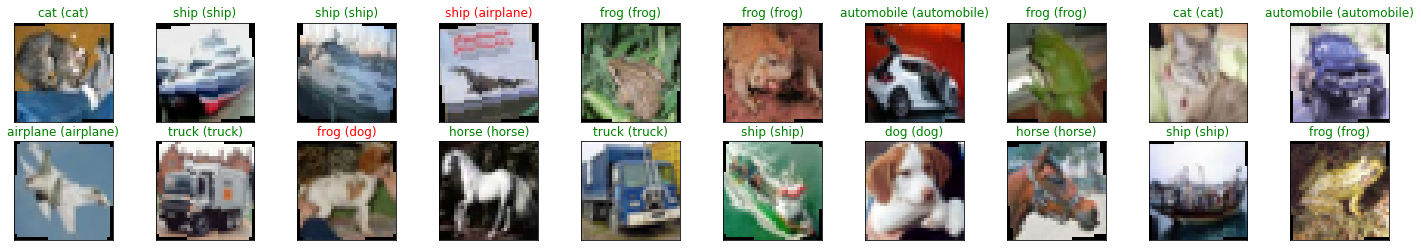

In [70]:
# Plot das previsões
fig = plt.figure(figsize = (25, 4))
print("\nEntre parênteses a classe real. Vermelho indica erro do modelo.\n")
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
                 color = ("green" if preds[idx] == labels[idx].item() else "red"))

## Crédito de Imagem

CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html)



## Fonte de Conteúdo:

<p style="text-align: left;">Site: <a href="http://www.rodolfoterra.com">Rodolfo Terra | Ciência de dados</a></p>

<p style="text-align: left;">Blog: <a href="https://rodolffoterra.github.io/">Aprenda Gratuitamente Linguagem R & Python</a></p>


<p style="text-align: left;">Github: <a href="https://github.com/rodolffoterra">rodolffoterra</a></p>

<p><img style="float: right;" src="imagens/logo.png" alt="RNA" /></p><br><br><br><br><br>



